<a href="https://colab.research.google.com/github/JaniVarga/Skin_detection/blob/main/Skin_detection_trial_second_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin segmentation with different technic

I asked AI what techniques exist for skin detection and he listed the following possibilities:

* Thresholding in color spaces
* Gaussian Mixture Models (GMM)
* Historgram Backprojection
* Neural Networks
* Bayesian Classifiers
* Support Vector Machines (SVM)

I have used a photo of a dear colleague to see which method performs.



## Thresholding in color spaces

I have based this chapter on two publications

* https://arxiv.org/pdf/1708.02694
* link result: https://www.researchgate.net/profile/Romi-Rahmat/publication/311402007_Skin_Color_Segmentation_Using_Multi-Color_Space_Threshold/links/5e46c493458515072d9da7db/Skin-Color-Segmentation-Using-Multi-Color-Space-Threshold.pdf

Both publications use different color spaces to reach good results for skin detection.

These are the RGB, HSV and YCbCr color spaces, in addition, there are many other color spaces.

Here is a link about the color spaces: https://en.wikipedia.org/wiki/Color_space

In [1]:
# Imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Setup image path
img_1_path = "/content/1728293261557.jpeg"

In [3]:
# Open images with PIL
with Image.open(img_1_path) as img_1:
  img_1.load()

In [4]:
# Check images mode and size
img_1.mode, img_1.size

('RGB', (1080, 1920))

In [5]:
# Resize the image
img_1 = img_1.reduce(4)
img_1.mode, img_1.size

('RGB', (270, 480))

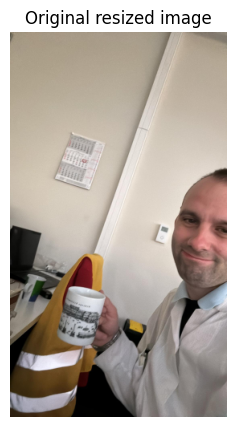

In [6]:
# Plot the image
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(img_1)
ax.set_title("Original resized image")
ax.axis("off")
plt.show()

### Skin detection in RGB color space.


In [7]:
# Make a function to split an image into R, G, B channels
def rgb_channels(image):
  """
  Split RGB image into R, G, B channels.

  Args:
  image: PIL Image object

  Returns:
  R, G, B channels as numpy arrays
  """
  # Convert PIL Image to numpy array
  image = np.array(image)
  # Get R, G, B components
  r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]

  return r, g, b

In [8]:
red_channel, green_channel, blue_channel = rgb_channels(img_1)

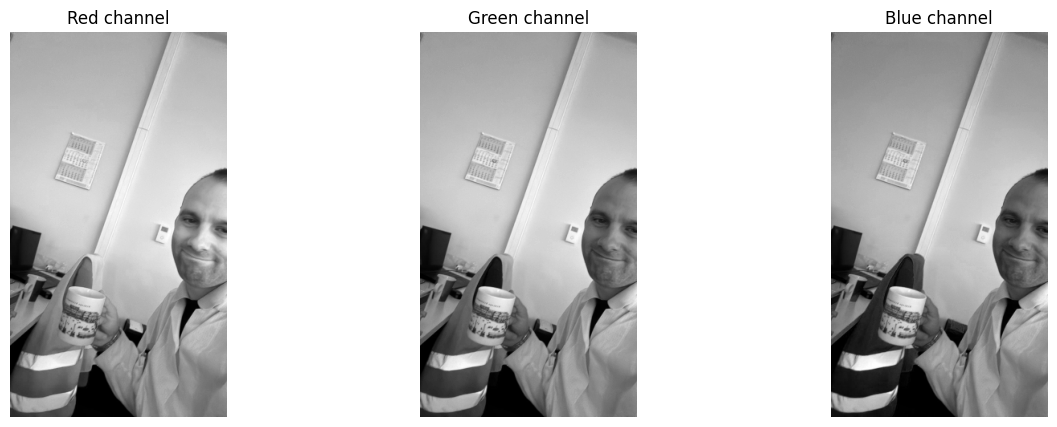

In [9]:
# Visualize Red,Green,Blue color channels
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(red_channel, cmap='gray')
ax[0].set_title("Red channel")
ax[0].axis("off")
ax[1].imshow(green_channel, cmap='gray')
ax[1].set_title("Green channel")
ax[1].axis("off")
ax[2].imshow(blue_channel, cmap='gray')
ax[2].set_title("Blue channel")
ax[2].axis("off")
plt.show()

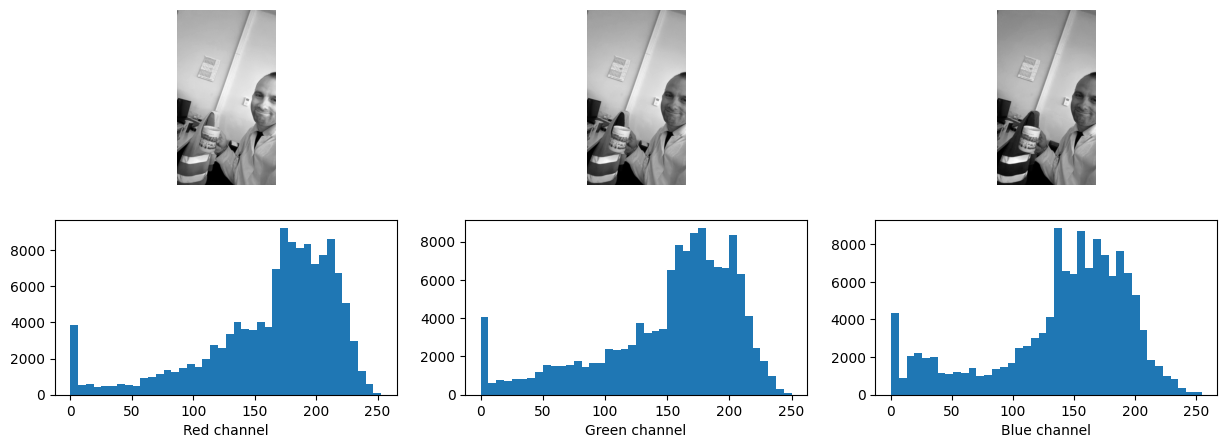

In [10]:
fig, ax = plt.subplots(2,3, figsize=(15,5))

ax[0,0].imshow(red_channel, cmap='gray')
ax[0,0].axis("off")
ax[0,1].imshow(green_channel, cmap='gray')
ax[0,1].axis("off")
ax[0,2].imshow(blue_channel, cmap='gray')
ax[0,2].axis("off")
ax[1, 0].hist(red_channel.ravel(), bins=40, range=(red_channel.min(), red_channel.max()))
ax[1, 0].set_xlabel('Red channel')
ax[1, 1].hist(green_channel.ravel(), bins=40, range=(green_channel.min(), green_channel.max()))
ax[1, 1].set_xlabel('Green channel')
ax[1, 2].hist(blue_channel.ravel(), bins=40, range=(blue_channel.min(), blue_channel.max()))
ax[1, 2].set_xlabel('Blue channel')

plt.show()

In [11]:
face_red = red_channel[200:310, 220:270]
face_green = green_channel[200:310, 220:270]
face_blue = blue_channel[200:310, 220:270]

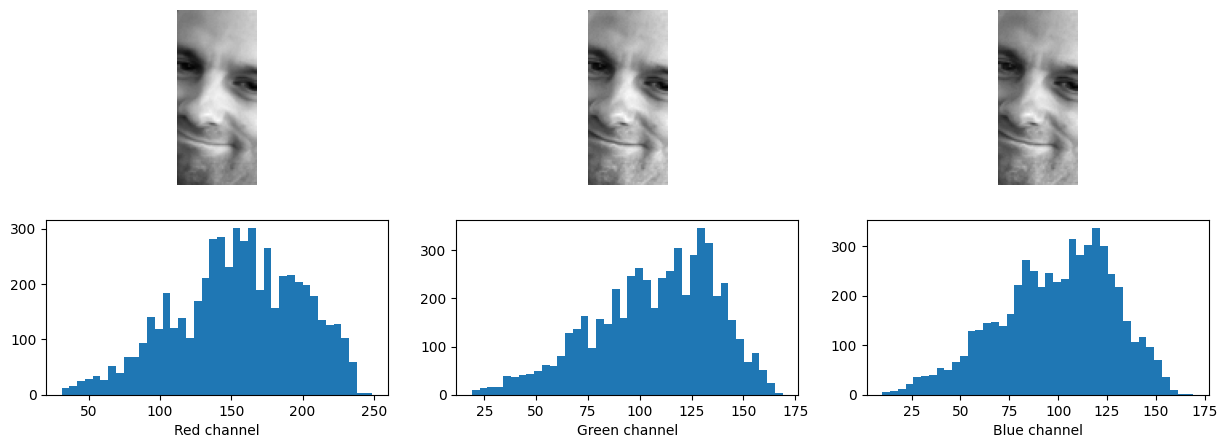

In [12]:
fig, ax = plt.subplots(2,3, figsize=(15,5))

ax[0,0].imshow(face_red, cmap='gray')
ax[0,0].axis("off")
ax[0,1].imshow(face_green, cmap='gray')
ax[0,1].axis("off")
ax[0,2].imshow(face_blue, cmap='gray')
ax[0,2].axis("off")
ax[1, 0].hist(face_red.ravel(), bins=40)
ax[1, 0].set_xlabel('Red channel')
ax[1, 1].hist(face_green.ravel(), bins=40)
ax[1, 1].set_xlabel('Green channel')
ax[1, 2].hist(face_blue.ravel(), bins=40)
ax[1, 2].set_xlabel('Blue channel')

plt.show()

In [13]:
face_red.min(), face_red.max(), face_green.min(), face_green.max(), face_blue.min(), face_blue.max()

(31, 249, 19, 169, 10, 169)

In [14]:
low_color = (31,19,10)
up_color = (249,169,169)
offset = 20

In [15]:
def make_my_mask(image ,light_color, dark_color, offset):
  """
  Make a mask for the image.

  Args:
  image: PIL Image object
  light_color: tuple (R, G, B)
  dark_color: tuple (R, G, B)
  offset: int

  Returns:
  mask: numpy array
  """
  # Convert PIL Image to numpy array
  image = np.array(image)

  mask_red = (light_color[0]+offset <= image[:,:,0]) & (image[:,:,0] <= dark_color[0]-offset)
  mask_green = (light_color[1]+offset <= image[:,:,1]) & (image[:,:,1] <= dark_color[1]-offset)
  mask_blue = (light_color[2]+offset <= image[:,:,2]) & (image[:,:,2]<= dark_color[2]-offset)

  logical_mask = np.logical_and(np.logical_and(mask_red, mask_green), mask_blue)
  mask = np.array([255 if x == True else 0 for x in np.nditer(logical_mask)]).reshape(image.shape[0], image.shape[1])

  return mask, mask_red, mask_green, mask_blue

In [16]:
rgb_mask, r, g, b =make_my_mask(img_1, low_color, up_color, offset)

In [17]:
digitalize = lambda logical_mask, image : np.array([255 if x == True else 0 for x in np.nditer(logical_mask)]).reshape(image.height, image.width)

In [18]:
mask_r = digitalize(logical_mask=r, image=img_1)
mask_g = digitalize(logical_mask=g, image=img_1)
mask_b = digitalize(logical_mask=b, image=img_1)

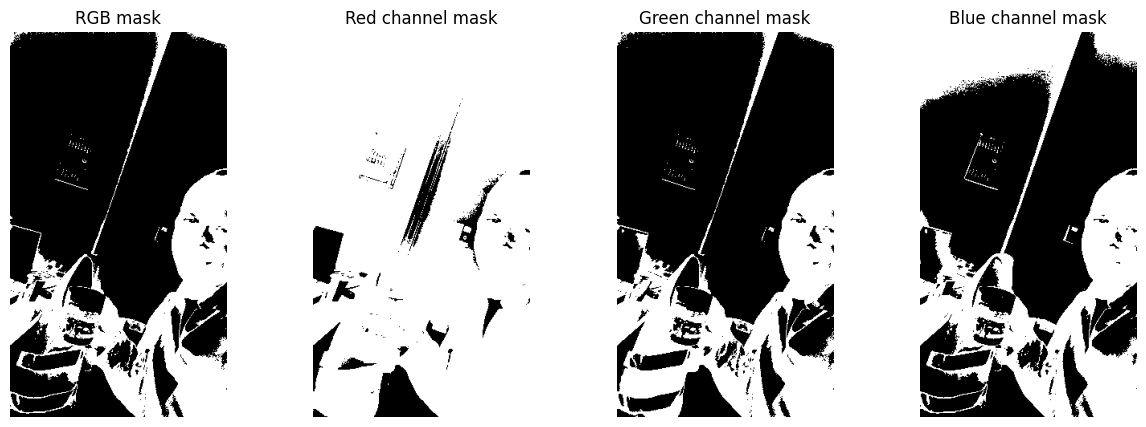

In [19]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].imshow(rgb_mask, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("RGB mask")
ax[0].axis("off")
ax[1].imshow(mask_r, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Red channel mask")
ax[1].axis("off")
ax[2].imshow(mask_g, cmap='gray', vmin=0, vmax=255)
ax[2].set_title("Green channel mask")
ax[2].axis("off")
ax[3].imshow(mask_b, cmap='gray', vmin=0, vmax=255)  # vmin=0, vmax=255 settings to show white pictures in
ax[3].set_title("Blue channel mask")
ax[3].axis("off")
plt.show()

In [20]:
def use_the_mask(image_to_customize, mask):
  img = image_to_customize.copy()
  for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      if mask[i,j] == 0:
        img.putpixel((j,i), (0,0,0))
  return img

In [21]:
result_rgb = use_the_mask(img_1, rgb_mask)

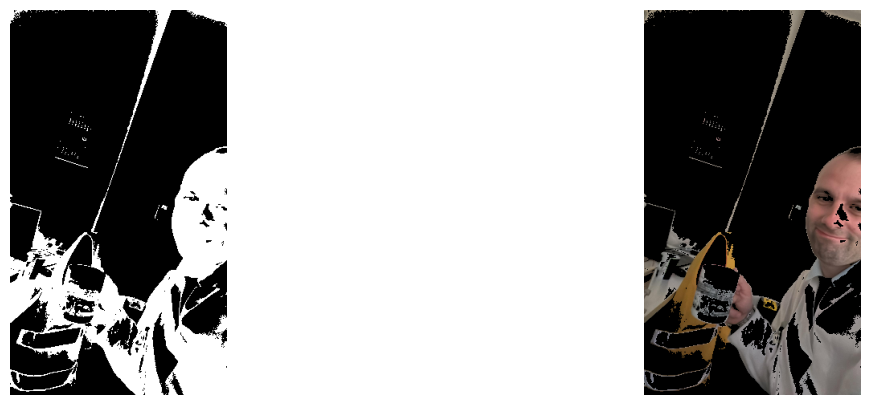

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(rgb_mask, cmap='gray')
ax[0].axis("off")
ax[1].imshow(result_rgb)
ax[1].axis("off")
plt.show()

According the first link they use the method below in RGB color space:

R > 95 and G > 40 and B > 20 and R > G and R > B
and | R - G | > 15 and A > 15

In [23]:
new_mask = (red_channel > 95) &  (green_channel > 40) & (blue_channel > 20) & (red_channel > green_channel) & (red_channel > blue_channel) & (np.abs(red_channel - green_channel) > 15) & (red_channel > 15)

In [24]:
rgb_mask_paper = np.array([255 if x == True else 0 for x in np.nditer(new_mask)]).reshape(img_1.height, img_1.width)

In [25]:
result_rgb_paper = use_the_mask(img_1, rgb_mask_paper)

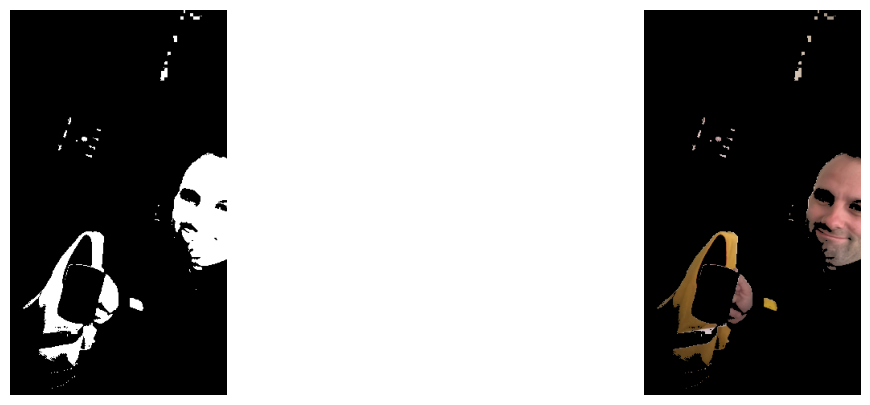

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(new_mask, cmap='gray')
ax[0].axis("off")
ax[1].imshow(result_rgb_paper)
ax[1].axis("off")
plt.show()

###  Skin detection in HSV color space.





In [27]:
# Open images with PIL
with Image.open(img_1_path) as img_1:
  img_1.load()

img_1 = img_1.reduce(4)

In [28]:
# Make a function to convert RGB -> H, S, V channels
def rgb_to_hsv(image):
  """
  Convert RGB image to HSV color space.
  """
  # 0.Convert "JpegImageFile" to numpy array
  image = np.array(image)
  # 1. Calculate R' = R/255, G' = G/255, B' = B/255
  image = image / 255
  # 2. Calculate the delta c_max - c_min
  c_max = np.max(image, axis=2)
  c_min = np.min(image, axis=2)
  delta = c_max - c_min
  # 3. Hue calculation
  hue = []
  for i, row in enumerate(image):
    for j, pixel in enumerate(row):
      if delta[i,j] == 0:
        hue.append(0)
      elif c_max[i,j] == pixel[0]:
        hue.append(((pixel[1] - pixel[2])/delta[i,j])%6)
      elif c_max[i,j] == pixel[1]:
        hue.append(2 + (pixel[2] - pixel[0])/delta[i,j])
      elif c_max[i,j] == pixel[2]:
        hue.append(4 + (pixel[0] - pixel[1])/delta[i,j])
      else:
        hue.append(0)

  hue = np.array(hue).reshape(image.shape[0], image.shape[1])
  hue = hue * 60
  # 4. Calculate saturation
  saturation = []
  for i, row in enumerate(image):
    for j, pixel in enumerate(row):
      saturation.append(0 if c_max[i,j] == 0 else (delta[i,j] / c_max[i,j]) * 100)

  saturation = np.array(saturation).reshape(image.shape[0], image.shape[1])
  # 5. Calculate value
  value = []
  for i, row in enumerate(image):
    for j, pixel in enumerate(row):
      value.append(c_max[i,j] * 100)

  value = np.array(value).reshape(image.shape[0], image.shape[1])

  return hue, saturation, value

In [29]:
h, s, v = rgb_to_hsv(img_1) # h -> 0 - 360° | s: 0 - 100 % | v 0 - 100%

In [30]:
h.min() , h.max(), s.min(), s.max(), v.min(), v.max()

(0.0, 359.36170212765956, 0.0, 100.0, 0.0, 100.0)

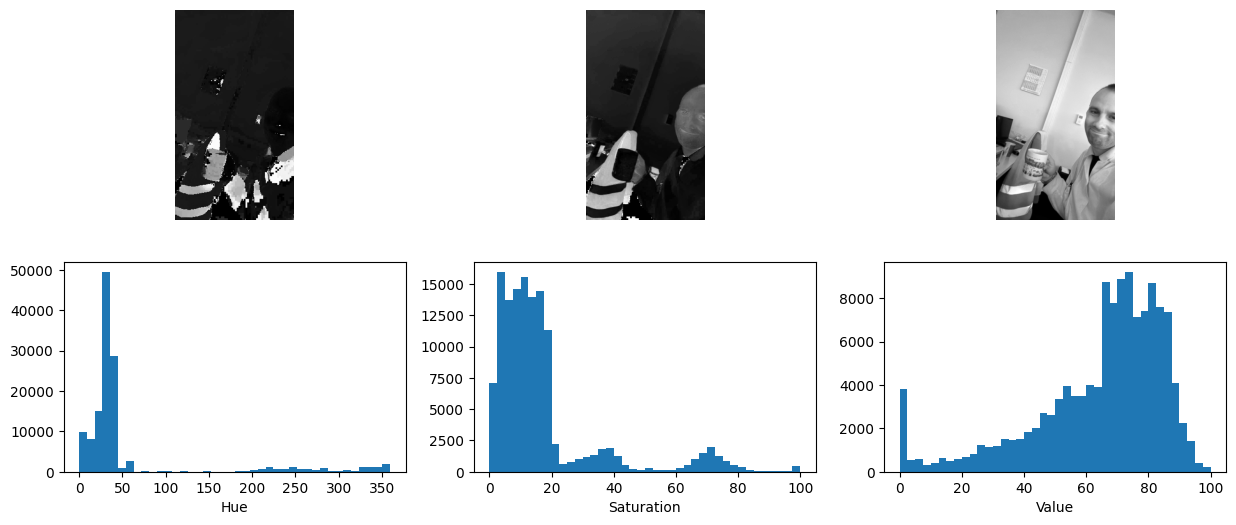

In [31]:
# Visualize H, S, V color channels
fig, ax = plt.subplots(2,3, figsize=(15,6))

ax[0,0].imshow(h, cmap='gray')
ax[0,0].axis("off")
ax[0,1].imshow(s, cmap='gray')
ax[0,1].axis("off")
ax[0,2].imshow(v, cmap='gray')
ax[0,2].axis("off")
ax[1, 0].hist(h.ravel(), bins=40, range=(h.min(), h.max()))
ax[1, 0].set_xlabel('Hue')
ax[1, 1].hist(s.ravel(), bins=40, range=(s.min(), s.max()))
ax[1, 1].set_xlabel('Saturation')
ax[1, 2].hist(v.ravel(), bins=40, range=(v.min(), v.max()))
ax[1, 2].set_xlabel('Value')

plt.show()

In [32]:
face_h = h[200:310, 220:270]
face_s = s[200:310, 220:270]
face_v = v[200:310, 220:270]

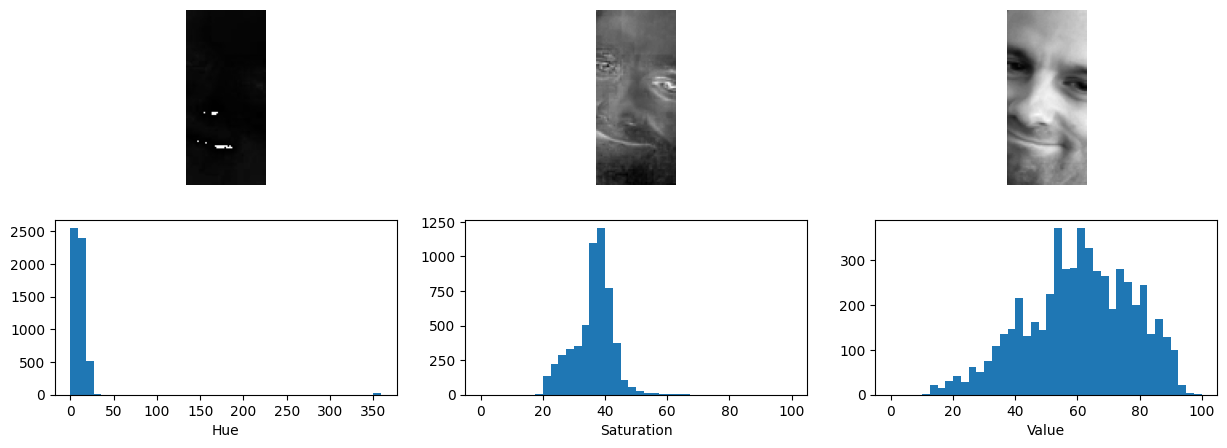

In [33]:
fig, ax = plt.subplots(2,3, figsize=(15,5))

ax[0,0].imshow(face_h, cmap='gray')
ax[0,0].axis("off")
ax[0,1].imshow(face_s, cmap='gray')
ax[0,1].axis("off")
ax[0,2].imshow(face_v, cmap='gray')
ax[0,2].axis("off")
ax[1, 0].hist(face_h.ravel(), bins=40, range=(h.min(), h.max()))
ax[1, 0].set_xlabel('Hue')
ax[1, 1].hist(face_s.ravel(), bins=40, range=(s.min(), s.max()))
ax[1, 1].set_xlabel('Saturation')
ax[1, 2].hist(face_v.ravel(), bins=40, range=(v.min(), v.max()))
ax[1, 2].set_xlabel('Value')

plt.show()

In [34]:
h.min(), h.max(), s.min(), s.max(), v.min(), v.max()

(0.0, 359.36170212765956, 0.0, 100.0, 0.0, 100.0)

In [35]:
light_skin_tone_hsv = (0, 28, 0)
dark_skin_tone_hsv = (25, 68, 100)

In [36]:
def make_mask(image ,light_color, dark_color):
  mask_h = np.array([255 if light_color[0] <= x <= dark_color[0] else 0 for x in np.nditer(h)]).reshape(image.height, image.width)
  mask_s = np.array([255 if light_color[1] <= x <= dark_color[1] else 0 for x in np.nditer(s)]).reshape(image.height, image.width)
  mask_v = np.array([255 if light_color[2] <= x <= dark_color[2] else 0 for x in np.nditer(v)]).reshape(image.height, image.width)
  logical_mask = np.logical_and(np.logical_and(mask_h, mask_s), mask_v)
  mask = np.array([255 if x == True else 0 for x in np.nditer(logical_mask)]).reshape(image.height, image.width)

  return mask, mask_h, mask_s, mask_v

In [37]:
mask_hsv, mask_h, mask_s, mask_v = make_mask(img_1, light_skin_tone_hsv, dark_skin_tone_hsv)

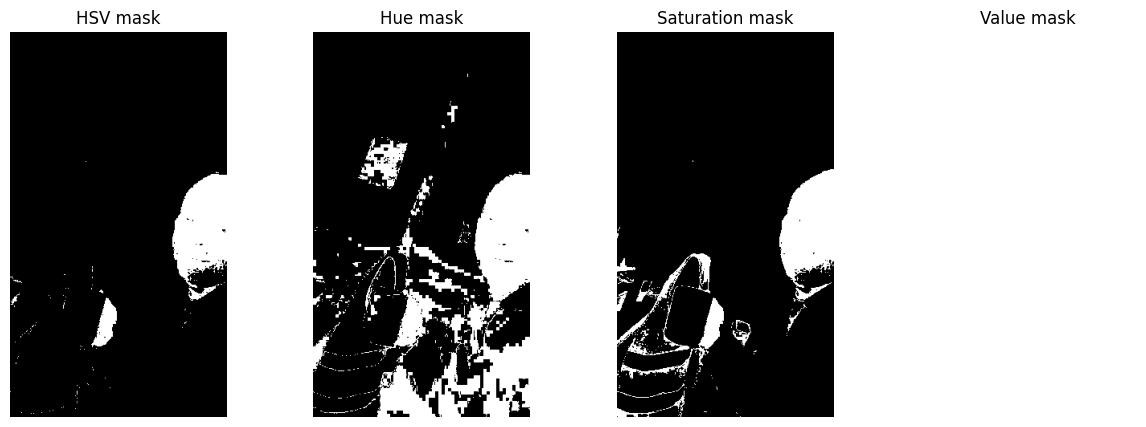

In [38]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].imshow(mask_hsv, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("HSV mask")
ax[0].axis("off")
ax[1].imshow(mask_h, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Hue mask")
ax[1].axis("off")
ax[2].imshow(mask_s, cmap='gray', vmin=0, vmax=255)
ax[2].set_title("Saturation mask")
ax[2].axis("off")
ax[3].imshow(mask_v, cmap='gray', vmin=0, vmax=255)  # vmin=0, vmax=255 settings to show white pictures in
ax[3].set_title("Value mask")
ax[3].axis("off")
plt.show()

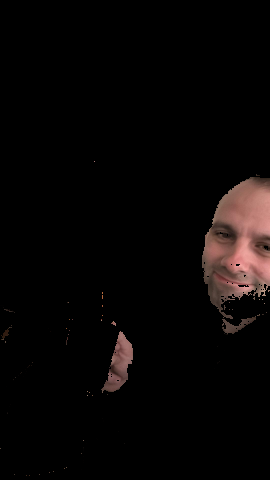

In [39]:
hsv_mask = use_the_mask(img_1, mask_hsv)
hsv_mask

According the first link they use the method below in RGB color space:
0.0 <= H <= 50.0 and 0.23 <= S <= 0.68

In [40]:
new_mask_2 = ((h >= 0) & (h <= 50)) &  ((s >=23) & (s <=68))

In [41]:
result_hsv_paper = np.array([255 if x == True else 0 for x in np.nditer(new_mask_2)]).reshape(img_1.height, img_1.width)

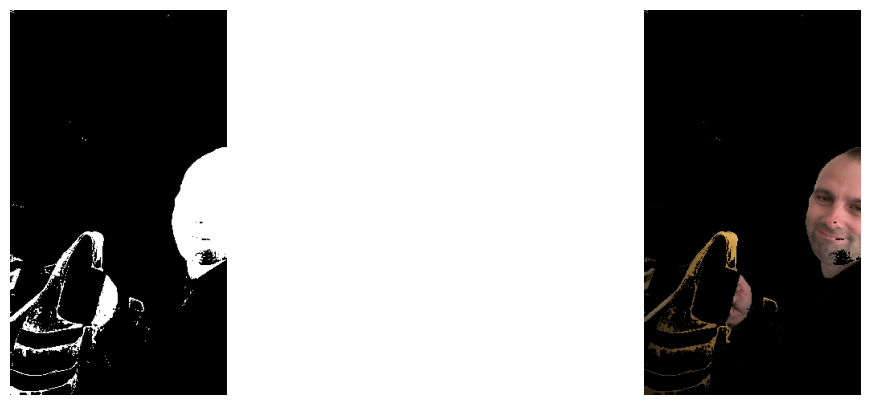

In [42]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(new_mask_2, cmap='gray')
ax[0].axis("off")
ax[1].imshow(use_the_mask(img_1, result_hsv_paper))
ax[1].axis("off")
plt.show()

In [43]:
mask_1 = new_mask & new_mask_2

In [44]:
new_mask_half = np.array([255 if x == True else 0 for x in np.nditer(mask_1)]).reshape(img_1.height, img_1.width)

In [45]:
new_mask_paper = use_the_mask(img_1,new_mask_half)

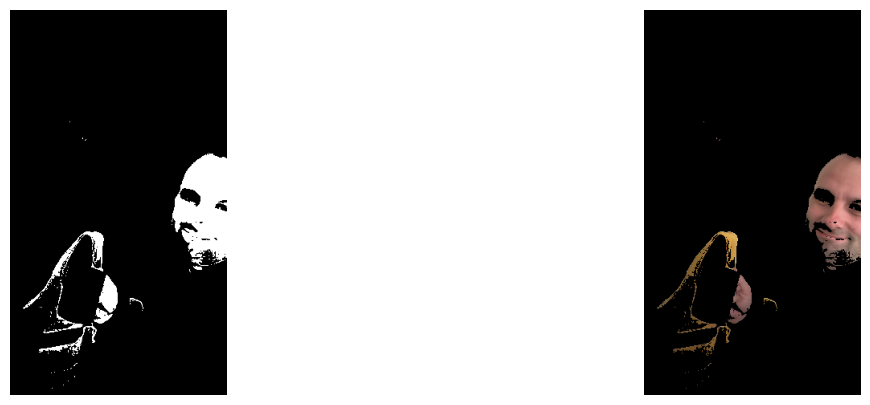

In [46]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(new_mask_half, cmap='gray')
ax[0].axis("off")
ax[1].imshow(new_mask_paper)
ax[1].axis("off")
plt.show()

The final detection method looks like

R > 95 and G > 40 and B > 20 and R > G and R > B
and | R - G | > 15 and A > 15 and Cr > 135 and
Cb > 85 and Y > 80 and Cr <= (1.5862*Cb)+20 and
Cr>=(0.3448*Cb)+76.2069 and
Cr >= (-4.5652*Cb)+234.5652 and
Cr <= (-1.15*Cb)+301.75 and
Cr <= (-2.2857*Cb)+432.85

This part is already done.(new mask)

R > 95 and G > 40 and B > 20 and R > G and R > B and | R - G | > 15 and A > 15

The remainig part:
 Cr > 135 and Cb > 85 and Y > 80 and Cr <= (1.5862Cb)+20 and Cr>=(0.3448Cb)+76.2069 and Cr >= (-4.5652Cb)+234.5652 and Cr <= (-1.15Cb)+301.75 and Cr <= (-2.2857*Cb)+432.85

 This part is in YCbCr color space.

In [47]:
# Open images with PIL
with Image.open(img_1_path) as img_1:
  img_1.load()

img_1 = img_1.reduce(4)

In [48]:
def rgb_to_ycbcr(image):

  image = np.array(image)
  r,g,b = image[:,:,0], image[:,:,1], image[:,:,2]

  y = 0.299*r + 0.587*g + 0.114*b
  cb = 128 - 0.168736*r - 0.3312*g + 0.500*b
  cr = 128 + 0.5*r - 0.4186*g - 0.081*b

  y = y.astype(np.uint8)
  cb = cb.astype(np.uint8)
  cr = cr.astype(np.uint8)

  return y, cb, cr

In [49]:
y, cb, cr = rgb_to_ycbcr(img_1)

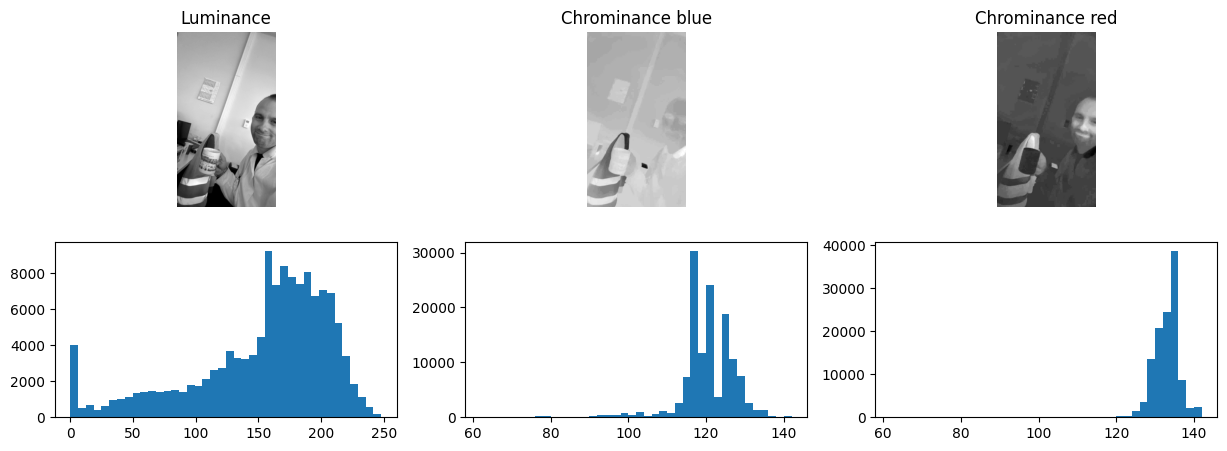

In [50]:
# Visualize Y,Cb,Cr color channels
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax[0,0].imshow(y, cmap='gray')
ax[0,0].set_title("Luminance")
ax[0,0].axis("off")
ax[0,1].imshow(cb, cmap='gray')
ax[0,1].set_title("Chrominance blue")
ax[0,1].axis("off")
ax[0,2].imshow(cr, cmap='gray')
ax[0,2].set_title("Chrominance red")
ax[0,2].axis("off")
ax[1, 0].hist(y.ravel(), bins=40, range=(y.min(), y.max()))
ax[1, 1].hist(cb.ravel(), bins=40, range=(cb.min(), cb.max()))
ax[1, 2].hist(cr.ravel(), bins=40, range=(cb.min(), cb.max()))

plt.show()

In [51]:
mask_y_cb_cr = (cr > 135) & (cb > 85) & (y > 80 ) & (cr <= (1.5862*cb)+20) & (cr>=(0.3448*cb)+76.2069) & (cr >= (-4.5652*cb)+234.5652) & (cr <= (-1.15*cb)+301.75) & (cr <= (-2.2857*cb)+432.85)

In [52]:
mask_y_cb_cr = np.array([255 if x == True else 0 for x in np.nditer(mask_y_cb_cr)]).reshape(img_1.height, img_1.width)

In [53]:
mask_y_cb_cr_paper_half = use_the_mask(img_1, mask_y_cb_cr)

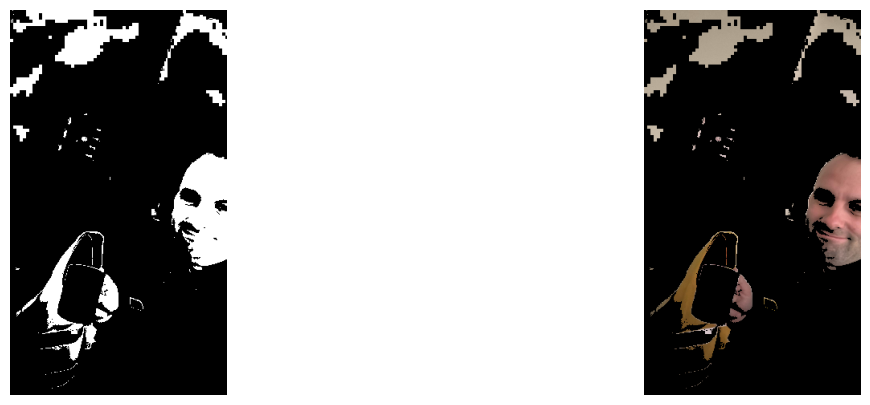

In [54]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(mask_y_cb_cr, cmap='gray')
ax[0].axis("off")
ax[1].imshow(mask_y_cb_cr_paper_half)
ax[1].axis("off")
plt.show()

In [55]:
mask_or_half = mask_y_cb_cr & new_mask

In [56]:
mask_or_half_binarized = np.array([255 if x == True else 0 for x in np.nditer(mask_or_half)]).reshape(img_1.height, img_1.width)

In [57]:
final_half_second = use_the_mask(img_1, mask_or_half_binarized)

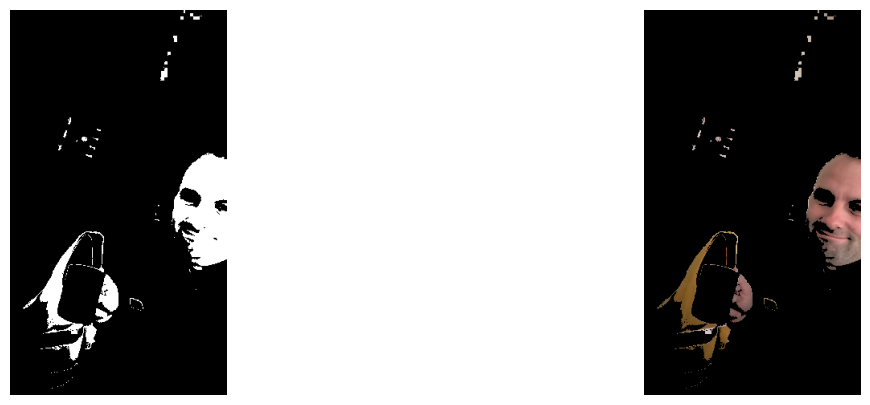

In [58]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(mask_or_half, cmap='gray')
ax[0].axis("off")
ax[1].imshow(final_half_second)
ax[1].axis("off")
plt.show()

In [59]:
final_mask = np.logical_or(mask_or_half, mask_1)

In [60]:
final_mask_binarized = np.array([255 if x == True else 0 for x in np.nditer(final_mask)]).reshape(img_1.height, img_1.width)

In [61]:
final_mask_image = use_the_mask(img_1, final_mask_binarized)

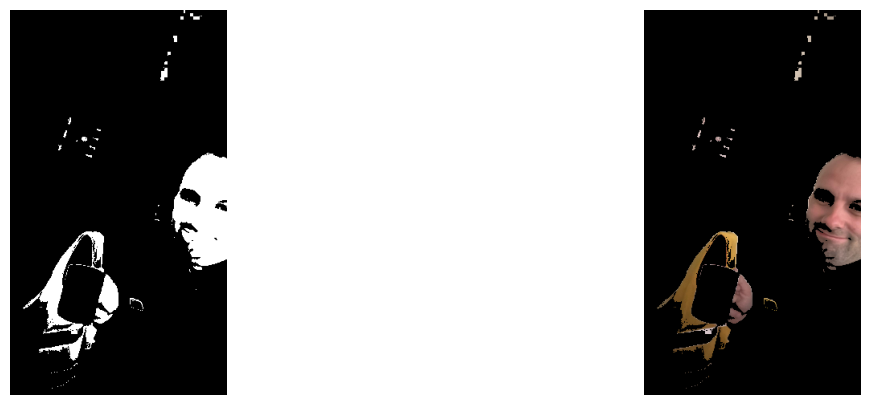

In [62]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(final_mask_binarized, cmap='gray')
ax[0].axis("off")
ax[1].imshow(final_mask_image)
ax[1].axis("off")
plt.show()

Other, second  paper

link result: https://www.researchgate.net/profile/Romi-Rahmat/publication/311402007_Skin_Color_Segmentation_Using_Multi-Color_Space_Threshold/links/5e46c493458515072d9da7db/Skin-Color-Segmentation-Using-Multi-Color-Space-Threshold.pdf

```
 (((R’ / G’) > 1.185) AND ((H >= 0) AND (H <= 25)) OR  ((H >= 335) AND (H <= 360)) AND ((S >= 0.2) AND (S <= 0.6)) AND ((Cb > 77) AND (Cb < 127)) AND    ((Cr > 133) AND (Cr < 173))  
```



In [63]:
def color_channels(image):
  """
  Convert a PIL(RGB) image to R, G, B, Y, Cb, Cr, Hue, Saturation, Value channels.
  """
  # Convert PIL Image to numpy array
  image = np.array(image)
  # Get R, G, B components
  r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]

  # Convert r, g, b channels to y, cb, cr channels
  y = 0.299*r + 0.587*g + 0.114*b
  cb = 128 - 0.168736*r - 0.3312*g + 0.500*b
  cr = 128 + 0.5*r - 0.4186*g - 0.081*b

  # y = y.astype(np.uint8)
  # cb = cb.astype(np.uint8)
  # cr = cr.astype(np.uint8)

  # Convert r, g, b channles to h, s, v channles

  # 1. Calculate R' = R/255, G' = G/255, B' = B/255
  image = image / 255
  # 2. Calculate the delta c_max - c_min
  c_max = np.max(image, axis=2)
  c_min = np.min(image, axis=2)
  delta = c_max - c_min
  # 3. Hue calculation
  hue = []
  for i, row in enumerate(image):
    for j, pixel in enumerate(row):
      if delta[i,j] == 0:
        hue.append(0)
      elif c_max[i,j] == pixel[0]:
        hue.append(((pixel[1] - pixel[2])/delta[i,j])%6)
      elif c_max[i,j] == pixel[1]:
        hue.append(2 + (pixel[2] - pixel[0])/delta[i,j])
      elif c_max[i,j] == pixel[2]:
        hue.append(4 + (pixel[0] - pixel[1])/delta[i,j])
      else:
        hue.append(0)

  hue = np.array(hue).reshape(image.shape[0], image.shape[1])
  hue = hue * 60
  # 4. Calculate saturation
  saturation = []
  for i, row in enumerate(image):
    for j, pixel in enumerate(row):
      saturation.append(0 if c_max[i,j] == 0 else (delta[i,j] / c_max[i,j]) * 100)

  saturation = np.array(saturation).reshape(image.shape[0], image.shape[1])
  # 5. Calculate value
  value = c_max * 100

  return r, g, b, y ,cb, cr, hue, saturation, value

In [64]:
img_1_path = "/content/1728293261557.jpeg"

In [65]:
# Open images with PIL
with Image.open(img_1_path) as img_1:
  img_1.load()

In [66]:
red_channel, green_channel, blue_channel, y, cb, cr, h, s, v = color_channels(img_1)

In [67]:
total = red_channel + green_channel + blue_channel+ 1e-8

In [68]:
mask_logic =  (((red_channel/total) / (green_channel/total)) > 1.185) & ((h >= 0) & (h <= 25)) |  ((h >= 335) &(h <= 360)) & ((s >= 0.2) & (s <= 0.6)) & ((cb > 77) & (cb < 127)) &  ((cr > 133) & (cr < 173))

<ipython-input-68-39258e01b0ad>:1: RuntimeWarning: divide by zero encountered in divide
  mask_logic =  (((red_channel/total) / (green_channel/total)) > 1.185) & ((h >= 0) & (h <= 25)) |  ((h >= 335) &(h <= 360)) & ((s >= 0.2) & (s <= 0.6)) & ((cb > 77) & (cb < 127)) &  ((cr > 133) & (cr < 173))
<ipython-input-68-39258e01b0ad>:1: RuntimeWarning: invalid value encountered in divide
  mask_logic =  (((red_channel/total) / (green_channel/total)) > 1.185) & ((h >= 0) & (h <= 25)) |  ((h >= 335) &(h <= 360)) & ((s >= 0.2) & (s <= 0.6)) & ((cb > 77) & (cb < 127)) &  ((cr > 133) & (cr < 173))


In [69]:
final_mask_binarized_second_option = np.array([255 if x == True else 0 for x in np.nditer(mask_logic)]).reshape(img_1.height, img_1.width)

In [70]:
final_mask_image_2 = use_the_mask(img_1, final_mask_binarized_second_option)

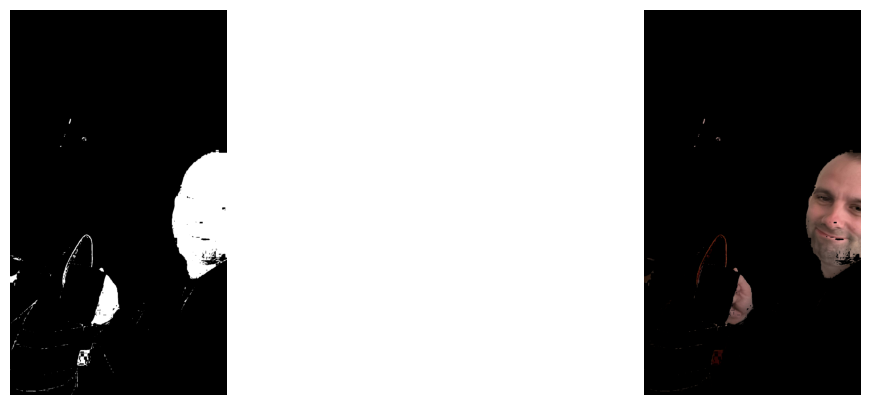

In [71]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(final_mask_binarized_second_option, cmap='gray')
ax[0].axis("off")
ax[1].imshow(final_mask_image_2)
ax[1].axis("off")
plt.show()

In [72]:
# Open images with PIL
with Image.open(img_1_path) as img_1:
  img_1.load()

In [73]:
red_channel, green_channel, blue_channel, y, cb, cr, h, s, v = color_channels(img_1)

In [74]:
mask_first_half = (red_channel > 95) &  (green_channel > 40) & (blue_channel > 20) & (red_channel > green_channel) & (red_channel > blue_channel) & (np.abs(red_channel - green_channel) > 15) & (red_channel > 15) & ((h >= 0) & (h <= 50)) &  ((s >=23) & (s <=68))

In [75]:
mask_seconf_half = (red_channel > 95) &  (green_channel > 40) & (blue_channel > 20) & (red_channel > green_channel) & (red_channel > blue_channel) & (np.abs(red_channel - green_channel) > 15) & (red_channel > 15) & (cr > 135) & (cb > 85) & (y > 80 ) & (cr <= (1.5862*cb)+20) & (cr>=(0.3448*cb)+76.2069) & (cr >= (-4.5652*cb)+234.5652) & (cr <= (-1.15*cb)+301.75) & (cr <= (-2.2857*cb)+432.85)

In [76]:
mask_together = mask_first_half | mask_seconf_half

In [77]:
mask_together_binarized = np.array([255 if x == True else 0 for x in np.nditer(mask_together)]).reshape(img_1.height, img_1.width)

In [78]:
mask_used = use_the_mask(img_1, mask_together_binarized)

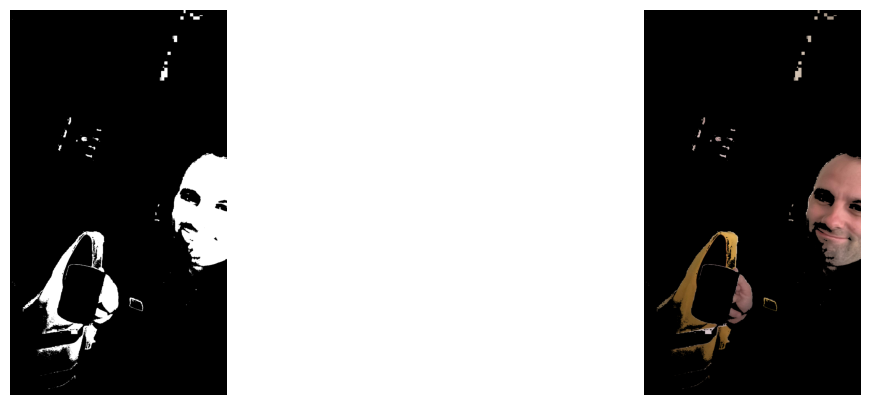

In [79]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(mask_together, cmap='gray')
ax[0].axis("off")
ax[1].imshow(mask_used)
ax[1].axis("off")
plt.show()

Plus one extra mask it made myself

In [80]:
my_own_mask = ((h >= 0) & (h <= 30)) & ((s >=28) & (s <=68))

In [81]:
my_own_mask_used = use_the_mask(img_1, my_own_mask)

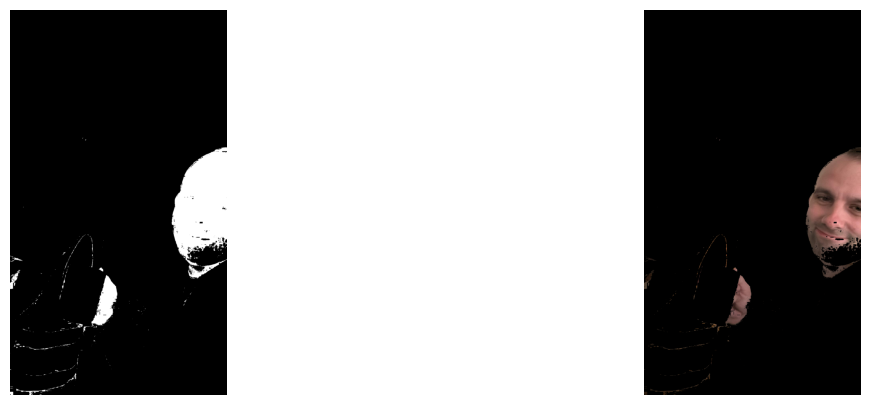

In [82]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(my_own_mask, cmap='gray')
ax[0].axis("off")
ax[1].imshow(my_own_mask_used)
ax[1].axis("off")
plt.show()

## GMM - Gaussian mixture model

link: https://towardsdatascience.com/image-processing-with-python-using-rg-chromaticity-c585e7905818





In [83]:
def rgb_to_RGB(image):
  image = np.array(image, dtype=np.float32)
  r,g,b = image[:,:,0], image[:,:,1], image[:,:,2]
  epsilon = 1e-6
  sum_rgb = r + g + b + epsilon
  red =  r / sum_rgb
  green =  g / sum_rgb

  return red, green

In [84]:
img_1_as_array = np.array(img_1)
img_1_cropped = img_1_as_array[200:310, 220:270]

In [85]:
crom_red_palette, crom_green_palette = rgb_to_RGB(img_1_cropped)
crom_matrix = 1-(crom_red_palette + crom_green_palette)

In [86]:
red_mean = np.mean(crom_red_palette)
red_std = np.std(crom_red_palette)
green_mean = np.mean(crom_green_palette)
green_std = np.std(crom_green_palette)
red_mean, red_std, green_mean, green_std

(0.3626864, 0.0015717354, 0.33870825, 0.0010555349)

In [87]:
crom_mean = np.mean(crom_matrix)
crom_std = np.std(crom_matrix)
crom_mean, crom_std

(0.29860538, 0.0015887504)

In [88]:
crom_red, crom_green = rgb_to_RGB(img_1)

In [89]:
image_chrom = 1-(crom_red + crom_green)

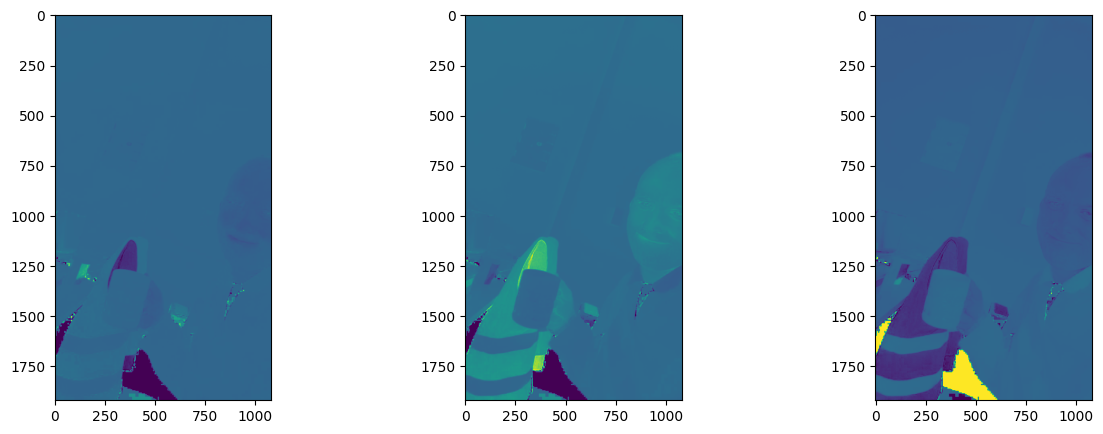

In [90]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[1].imshow(crom_red)
ax[0].imshow(crom_green)
ax[2].imshow(image_chrom)
plt.show()

In [91]:
def gaussian(p,mean,std):
    return np.exp(-(p-mean)**2/(2*std**2))*(1/(std*((2*np.pi)**0.5)))

In [92]:
crom_red = gaussian(crom_red, red_mean, red_std)
crom_green = gaussian(crom_green, green_mean, green_std)
chrom = gaussian(image_chrom, crom_mean, crom_std)

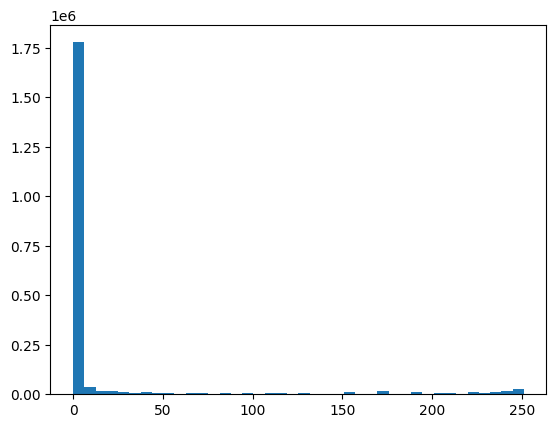

In [93]:
plt.hist(chrom.ravel(), bins=40, range=(chrom.min(), chrom.max()))
plt.show()

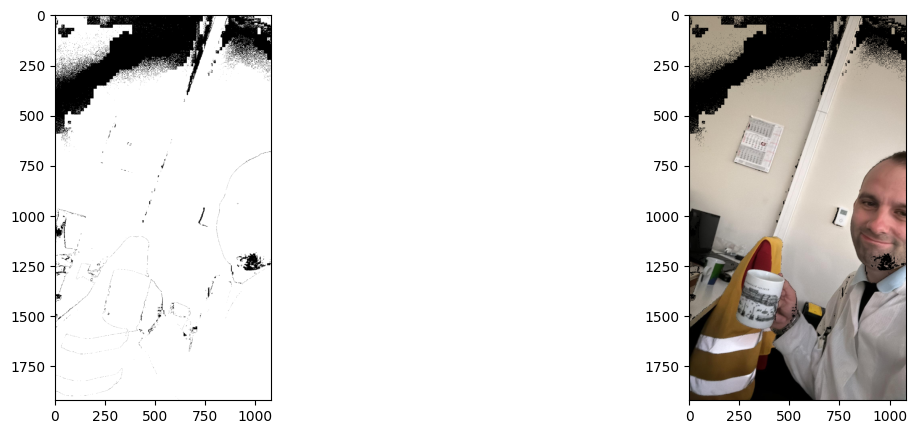

In [94]:
chrom_mask = chrom < chrom.mean()
binarized_chrome_mask = use_the_mask(img_1, chrom_mask)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(chrom_mask, cmap='gray')
ax[1].imshow(binarized_chrome_mask)
plt.show()

In [95]:
final_mask = crom_red + crom_green

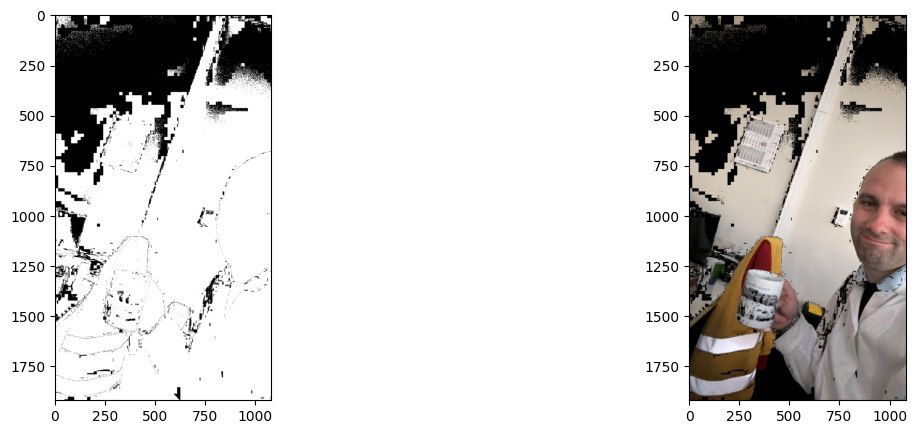

In [96]:
final_mask= final_mask < final_mask.mean()
binarized_final_mask = use_the_mask(img_1, final_mask)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(final_mask, cmap='gray')
ax[1].imshow(binarized_final_mask)
plt.show()

## Histogram Backprojection

https://theailearner.com/2019/04/18/histogram-backprojection/

https://docs.opencv.org/4.x/dc/df6/tutorial_py_histogram_backprojection.html

In [97]:
# Open the image
img_1_path = "/content/1728293261557.jpeg"
with Image.open(img_1_path) as img_1:
  img_1.load()

img_1 = img_1.reduce(4)

In [98]:
h, s, v = rgb_to_hsv(img_1)

In [99]:
img_1_hsv = np.dstack((h,s,v)).astype(np.float32)

In [100]:
roi = img_1_hsv[200:310, 220:270]

In [101]:
import cv2

roi_hist = cv2.calcHist([roi],[0, 1], None, [361, 101], [0, 361, 0, 101] )
target_hist = cv2.calcHist([img_1_hsv],[0, 1], None, [361, 101], [0, 361, 0, 101] )

In [102]:
target_hist = target_hist + 1e-17

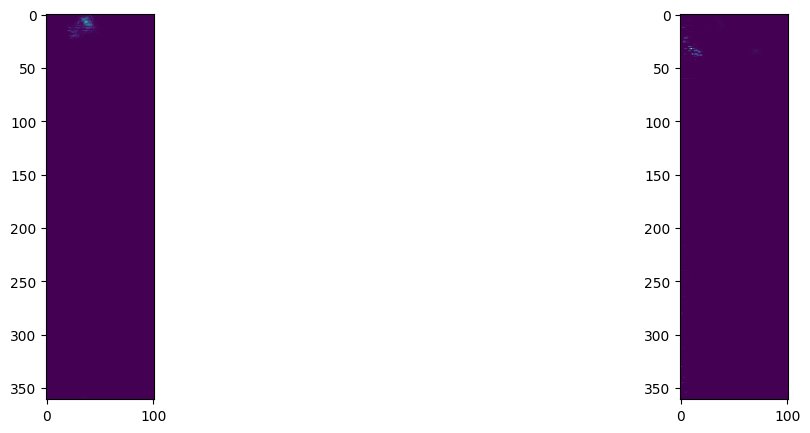

In [103]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(roi_hist)
ax[1].imshow(target_hist)

In [104]:
R = roi_hist/ target_hist

In [105]:
h = h.astype(int)
s = s.astype(int)

In [106]:
B = R[h.ravel(),s.ravel()]

In [107]:
B = np.minimum(B,1)
B = B.reshape(img_1_hsv.shape[:2])

In [108]:
B[200:310, 220:270].min(),  B[200:310, 220:270].max()

(0.0, 1.0)

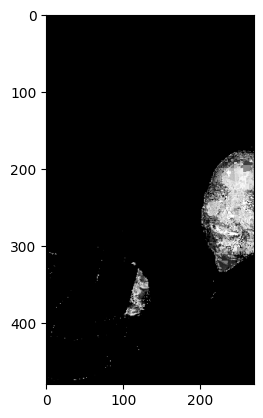

In [109]:
plt.imshow(B, cmap='gray')
plt.show()

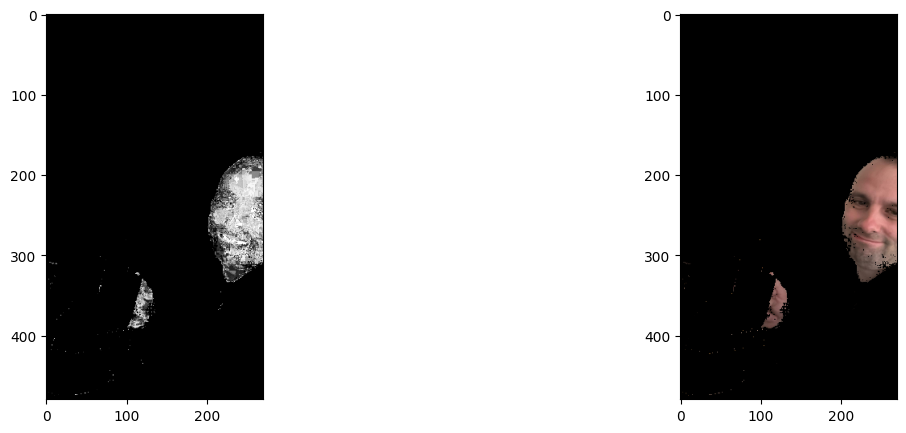

In [110]:
binarized_mask = use_the_mask(img_1, B)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(B, cmap='gray')
ax[1].imshow(binarized_mask)
plt.show()

## Neural Networks

**Image segmentation:**
Image segmentation is a computer vision technique that partitions a digital image into discrete groups of pixels—image segments—to inform object detection and related tasks

Image segmentation processes visual data at the pixel level, using various techniques to annotate individual pixels as belonging to a specific class or instance.

Image segmentation is used for three types of tasks:
* **semantic segmentation**
* **instance segmentation**
* **panoptic segmentation**


**Semantic segmentation**:

Semantic segmentation treats all pixels as *stuff*; it does not differentiate between *stuff* and things.

*Stuff*: Stuff refers to semantic classes that are amorphously shaped and highly variable in size, like “sky” or “water” or “grass”. Typically, stuff does not have clearly defined, countable individual instances. Unlike things, stuff does not have distinct parts: a blade of grass and field of grass are both equally “grass”.

**Instance segmentation**:

Instance segmentation inverts the priorities of semantic segmentation: whereas semantic segmentation algorithms predict only semantic classification of each pixel (with no regard for individual instances), instance segmentation delineates the exact shape of each separate object instance. Instance segmentation isolates things from stuff—which it ignores—and can thus be understood as an evolved form of object detection that outputs a precise segmentation mask instead of an approximate bounding box.

**Panoptic segmentation**:

Panoptic segmentation models both determine semantic classification of all pixels and differentiate each object instance in an image, combining the benefits of both semantic and instance segmentation.
In a panoptic segmentation task, each pixel must be annotated with both a semantic label and an “instance ID”. Pixels sharing the same label and ID belong to the same object; for pixels determined to be stuff, instance ID is ignored.





https://docs.ultralytics.com/tasks/segment

https://www.ibm.com/topics/image-segmentation